In [107]:
import numpy as np

In [164]:
class DeepNN():
    def __init__(self, X, Y, dims_of_layers, activations, alpha = 0.01, l2_reg = 0):
        #dims_of_layers - list of number of units in each layer (first element - num of features in input)
        #activations - activation function applied to each layer

        #dims_of_layers[0] - n of features in input
        #activations[0] - activation for first hidden layer
        #we support only 3 activation funcs: linear, sigmoid, relu

        #X.shape should be (n_features, m_examples)
        #Y.shape should be (1, m_examples)

        #regularization - regularization rate
        self.X = X
        self.Y = Y

        self.m_examples = X.shape[1]

        self.dims_of_layers = dims_of_layers
        self.n_layers = len(activations)

        self.activations = activations
        self.params = dict()

        self.learning_history = []

        self.alpha = alpha
        self.l2_reg = l2_reg

        #setting cache dicts for backpropogation

        self.cache = dict()

    def initialize_params(self):
      #Now, we are going to use He-initialization of weights

        for i in range(1, len(self.activations) + 1):

            #setting parameters layer by layer
            self.params["W" + str(i)] = np.random.randn(self.dims_of_layers[i], self.dims_of_layers[i-1])
            #multiplying by constant according to He init
            self.params["W" + str(i)] *=  np.sqrt(2 / (self.dims_of_layers[i-1]))


            self.params["b" + str(i)] = np.zeros((self.dims_of_layers[i], 1))



    def activation(self, Z, function="linear"):
        if function == "linear":
            return Z

        if function == "sigmoid":
            return 1 / (1 + np.exp(-Z))

        if function == "relu":
            return Z * (Z > 0)


    def deriv_activation(self, Z, function):
        if function == "linear":
            return 1.

        if function == "sigmoid":
            sigm_z = self.activation(Z, "sigmoid")

            return sigm_z *(1 - sigm_z)

        if function == "relu":
            return 1. * (Z > 0)



    def forward_propogation(self, X):

        #X.shape = (n_features, m_examples)

        A_prev = X
        self.cache["A0"]  = A_prev

        Z_current = np.dot(self.params["W1"], A_prev) + self.params["b1"]
        A_current = self.activation(Z_current, function=self.activations[0])

        self.cache["Z1"] = Z_current
        self.cache["A1"] = A_current

        for i in range(1, len(self.activations)):
            A_prev = A_current

            #A_prev - cache["A" + str(i)]
            Z_current = np.dot(self.params["W" + str(i+1)], A_prev) + self.params["b" + str(i+1)]
            A_current = self.activation(Z_current, function=self.activations[i])

            #keeping values in cache for backprop
            self.cache["Z" + str(i+1)] = Z_current
            self.cache["A" + str(i+1)] = A_current


        predictions = A_current

        return predictions

    def compute_reg_penalty(self):

      penalty = 0
      for l in range(1, self.n_layers + 1):
        W_l = self.params["W" + str(l)]
        penalty += np.sum(np.square(W_l))

      penalty = penalty * (self.l2_reg / (2 * self.m_examples))

      return penalty




    def compute_cost(self, predictions, cost_function):
        #leave cost func as a parameter
        #so that we can use it futher not only for classification

        if cost_function == "cross_entropy":

            #lets cut off a  tiny constant to avoid log0 problem
            epsilon = 10 ** -15

            predictions = np.clip(predictions, epsilon, 1-epsilon)

            #BinaryCrossEntropy

            cost = (self.Y * np.log(predictions) +
                    (1 - self.Y) * np.log(1 - (predictions)) ) * (-1 / self.m_examples)

            cost = np.sum(cost, axis=1, keepdims=True) #sum up the columns

        if cost_function == "mse":

            cost = np.sum(((predictions - self.Y) ** 2) * (2 / self.m_examples), axis=1, keepdims=True)


        #computing regularization penalty
        if self.l2_reg> 0:

          reg_penalty = self.compute_reg_penalty()
          cost += reg_penalty



        return cost

    def deriv_of_cost(self, predictions, cost_function):

        if cost_function == "cross_entropy":

            #avoiding division by zero
            epsilon = 10 ** -15
            predictions = np.clip(predictions, epsilon, 1-epsilon)

            dAL = (predictions - self.Y) / (predictions * (1 - predictions))

        if cost_function == "mse":
            dAL = (predictions - self.Y)

        return dAL


    def back_propogation(self, predictions, cost_func):

        L = self.n_layers

        grads_cache = dict()

        for i in range(L, 0, -1):
            if i == L:
                dA_i = self.deriv_of_cost(predictions, cost_function=cost_func)
            else:

                dA_i = np.dot(self.params["W" + str(i+1)].T, grads_cache["dZ" + str(i+1)]) #ERROR MuSt be here
                #print("i =", i)
                # print("W=", self.params["W" + str(i+1)] )
                # print("dZ_next =", grads_cache["dZ" + str(i+1)])

                # print("W = ", self.params["W" + str(i+1)].T.shape)
                # print("W shape ", )
                # print("dZ shape" + str(i),  grads_cache["dZ" + str(i+1)].shape)
                #print("dA", dA_i)


            grads_cache["dA" + str(i)] = dA_i
            activation_i = self.activations[i-1]

            Z_i = self.cache["Z" + str(i)]
            A_prev = self.cache["A" + str(i-1)]
            W_i = self.params["W" + str(i)]

            #print("Activation = ", activation_i)
            dZ_i = dA_i * self.deriv_activation(Z_i, activation_i)

            #print("Sum of dZ_i", np.sum(dZ_i))

            #computing derivs for W, b

            #L2 regularization term
            l2_term = (self.l2_reg / self.m_examples) * W_i

            dW_i = (1 / self.m_examples) * np.dot(dZ_i, A_prev.T) + l2_term
            db_i = (1/ self.m_examples) * np.sum(dZ_i, axis=1, keepdims=True)


            #storing gradients
            grads_cache["dZ" + str(i)] = dZ_i
            grads_cache["dW" + str(i)] = dW_i
            grads_cache["db" + str(i)] = db_i

        return grads_cache

    def update_params(self, grads):

        for i in range(1, self.n_layers + 1):

            #updating by Gradient Descent
            self.params["W" + str(i)] -=  self.alpha * grads["dW" + str(i)]
            self.params["b" + str(i)] -= self.alpha * grads["db" + str(i)]


    def fit(self, epochs=100, cost_func="mse", debug=False):

        #fitting process

        #initialize random params

        history = []
        self.initialize_params()


        for epoch in range(0, epochs + 1):

            predictions = self.forward_propogation(self.X)

            #computing cost function
            cost = np.round(self.compute_cost(predictions, cost_func), 6)
            history.append(cost)


            if (epoch % max(1 , (epochs // 20)) == 0):
              print("Epoch #{},  {} == {}".format(epoch, cost_func, cost))

            #computing gradients
            grads = self.back_propogation(predictions, cost_func=cost_func)
            if debug == True:
              print(grads)

            #update params using Gradient Descent
            self.update_params(grads)

        self.history = history

## Trying my DeepNN on syntetic dataset for binary classification



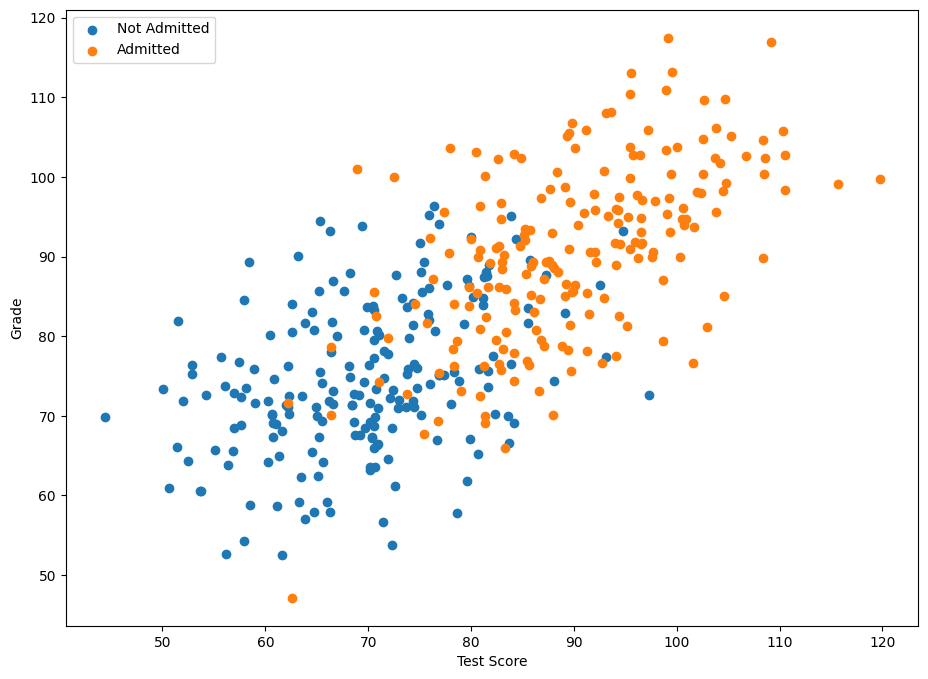

In [165]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Trying on a data

np.random.seed(2004)

# Generate data for not admitted students
mean_not_admitted = [70, 75]
cov_not_admitted = [[100, 50], [50, 100]]
not_admitted = np.random.multivariate_normal(mean_not_admitted, cov_not_admitted, size=200)

# Generate data for admitted students
mean_admitted = [90, 90]
cov_admitted = [[100, 50], [50, 100]]
admitted = np.random.multivariate_normal(mean_admitted, cov_admitted, size=200)

# Combine the data
X = np.vstack((not_admitted, admitted)) / 100
y = np.hstack((np.zeros(200), np.ones(200)))



# Plot the generated data

plt.figure(figsize=(11, 8))
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], label="Not Admitted")
plt.scatter(admitted[:, 0], admitted[:, 1], label="Admitted")
plt.xlabel("Test Score")
plt.ylabel("Grade")
plt.legend()
plt.show()

In [166]:
#my DeepNN

X_train,  X_test, y_train,y_test = train_test_split(X, y, random_state=1)




#transform for our NN

X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape(-1, 1).T
y_test = y_test.reshape(-1, 1).T



#Yes, I guess, it is too complicated for such a simple dataset
units = [X.shape[1], 5 , 5,  1]
activations = ["relu" , "relu" ,"sigmoid"]






In [167]:

l2_rate = 0.2

deepnn = DeepNN(X_train, y_train, units, activations,
                alpha = 0.01, l2_reg = l2_rate)

deepnn.fit(20000, "cross_entropy",debug=False)

Epoch #0,  cross_entropy == [[0.706723]]
Epoch #1000,  cross_entropy == [[0.665297]]
Epoch #2000,  cross_entropy == [[0.597216]]
Epoch #3000,  cross_entropy == [[0.474123]]
Epoch #4000,  cross_entropy == [[0.378496]]
Epoch #5000,  cross_entropy == [[0.349277]]
Epoch #6000,  cross_entropy == [[0.341566]]
Epoch #7000,  cross_entropy == [[0.339118]]
Epoch #8000,  cross_entropy == [[0.338193]]
Epoch #9000,  cross_entropy == [[0.337812]]
Epoch #10000,  cross_entropy == [[0.337569]]
Epoch #11000,  cross_entropy == [[0.337374]]
Epoch #12000,  cross_entropy == [[0.337202]]
Epoch #13000,  cross_entropy == [[0.337047]]
Epoch #14000,  cross_entropy == [[0.336899]]
Epoch #15000,  cross_entropy == [[0.336762]]
Epoch #16000,  cross_entropy == [[0.336636]]
Epoch #17000,  cross_entropy == [[0.336316]]
Epoch #18000,  cross_entropy == [[0.336028]]
Epoch #19000,  cross_entropy == [[0.33582]]
Epoch #20000,  cross_entropy == [[0.335428]]


In [168]:
predictions = np.round(np.array(deepnn.forward_propogation(X_test)).T)
train_predictions = np.round(np.array(deepnn.forward_propogation(X_train)).T)


In [169]:
from sklearn.metrics import accuracy_score


train_score = np.round(accuracy_score(y_train.T, train_predictions), 3)
test_score = np.round(accuracy_score(y_test.T, predictions), 3)

print("L2_reg_rate = ", l2_rate)
print("Train accuracy = {}; Test accuracy = {}".format(train_score, test_score))

L2_reg_rate =  0.2
Train accuracy = 0.86; Test accuracy = 0.87
